# About competition

If you have two sentences, there are three ways they could be related: one could entail the other, one could contradict the other, or they could be unrelated. Natural Language Inferencing (NLI) is a popular NLP problem that involves determining how pairs of sentences (consisting of a premise and a hypothesis) are related.

The task is to create an NLI model that assigns labels of 0, 1, or 2 (corresponding to entailment, neutral, and contradiction) to pairs of premises and hypotheses. To make things more interesting, the train and test set include text in fifteen different languages.

For more information on the problem, you can visit [Contradictory, My Dear Watson competition](https://www.kaggle.com/c/contradictory-my-dear-watson/overview)

# 1. Import Libraries

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# 2. Data Overview and EDA (Exploration Data Analysis)

The training set contains a premise, a hypothesis, a label (0 = entailment, 1 = neutral, 2 = contradiction), and the language of the text. For more information about what these mean and how the data is structured, check out the data page: https://www.kaggle.com/c/contradictory-my-dear-watson/data

## 2.1 Data Load

Let's load the data with the read_csv from Pandas.

In [88]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

## 2.2 Data Overview

Let's take a quick look on the training set.

In [89]:
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


Let's check the pairs of contradicting sentences.

In [90]:
print(train[train['label'] == 2]['premise'])

1        These are issues that we wrestle with in pract...
7                    From Cockpit Country to St. Ann's Bay
13             我希望你的领主能够最终开始认识到，向这样的人授予国王委员会的愚蠢行为反对我的所有建议。
14       म्जोडी का दावा है कि वह शादी करने के लिए मोरक्...
19       The streets are crammed with vendors selling s...
                               ...                        
12104    Да, - сказал Огле, - это правда. Но были и те,...
12110    Well, we've just got to get down to it, that's...
12115    The results of even the most well designed epi...
12117    The important thing is to realize that it's wa...
12118    At the west end is a detailed model of the who...
Name: premise, Length: 4064, dtype: object


For example, 12104 sentence is in Russian language.

In [91]:
print(train['premise'][12104])
print(train['hypothesis'][12104])

Да, - сказал Огле, - это правда. Но были и те, кто по-прежнему открыто и откровенно выступали против этого курса.
Огл никогда не упоминал противников существующего курса.


There is a clear contradiction between these sentences.

Let's look at the distribution of languages in the training set.

In [92]:
num_lang = train.groupby('language')['id'].count().sort_values(ascending=False).reset_index()
num_lang = pd.DataFrame(num_lang)
num_lang['count'] = num_lang['id']
num_lang = num_lang.drop('id',axis=1)
num_lang_data = num_lang.style.background_gradient(cmap='Greens')
num_lang_data

,language,count
0,English,6870
1,Chinese,411
2,Arabic,401
3,French,390
4,Swahili,385
5,Urdu,381
6,Vietnamese,379
7,Russian,376
8,Hindi,374
9,Greek,372


In [93]:
test_num_lang = test.groupby('language')['id'].count().sort_values(ascending=False).reset_index()
test_num_lang = pd.DataFrame(test_num_lang)
test_num_lang['count'] = test_num_lang['id']
test_num_lang = test_num_lang.drop('id',axis=1)
test_num_lang_data = test_num_lang.style.background_gradient(cmap='Oranges')
test_num_lang_data

,language,count
0,English,2945
1,Spanish,175
2,Russian,172
3,Swahili,172
4,Greek,168
5,Urdu,168
6,Turkish,167
7,Thai,164
8,Arabic,159
9,French,157


## 2.3 Data Visualization

In [94]:
fig = px.pie(num_lang,values='count',names='language',title='Language and their percentage in the train data :',color_discrete_sequence=px.colors.sequential.GnBu)
fig.update_traces(hoverinfo='label+percent', textfont_size=14,
                  marker=dict(line=dict(color='#000000', width=1.2)))
fig.show()

fig = px.pie(test_num_lang,values='count',names='language',title='Language and their percentage in the test data :',color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(hoverinfo='label+percent', textfont_size=14,
                  marker=dict(line=dict(color='#000000', width=1.2)))
fig.show()

It is obvious that English pairs of sentences are dominating. It is also good that data in the test and training sets is splitted equally.

Let's check if the dataset has NA spots.

In [95]:
print(train.isna().sum())
print(test.isna().sum())

id            0
premise       0
hypothesis    0
lang_abv      0
language      0
label         0
dtype: int64
id            0
premise       0
hypothesis    0
lang_abv      0
language      0
dtype: int64


The data is not missing any of the information.
Let's check the distribution between labels.

In [96]:
num_labels = train.groupby('label')['id'].count().sort_values(ascending=False).reset_index()
num_labels = pd.DataFrame(num_labels)
num_labels['count'] = num_labels['id']
num_labels = num_labels.drop('id',axis=1)
num_labels_data = num_labels.style.background_gradient(cmap='Reds')
num_labels_data

,label,count
0,0,4176
1,2,4064
2,1,3880


In [97]:
fig = px.pie(num_labels,values='count',names='label',title='Labels and their percentage in the train data :',color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(hoverinfo='label+percent', textfont_size=14,
                  marker=dict(line=dict(color='#000000', width=1.2)))
fig.show()

It is obvious that the labels are splitted more or less equally.

## 2.4 Text Processing Visualization

There is not much we can draw from regular data so let's jump into texts processing.

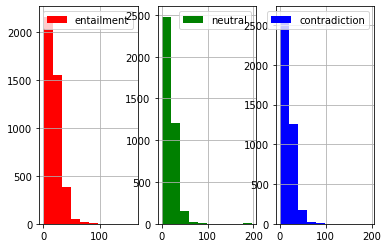

In [110]:
train['premise_len'] = train['premise'].apply(lambda x: len(x.split(' ')))
train['hypothesis_len'] = train['hypothesis'].apply(lambda x: len(x.split(' ')))

fig, ax = plt.subplots(1, 3)
train[train.label==0].premise_len.hist(ax=ax[0], color='red', label='entailment', bins=10)
ax[0].legend();
train[train.label==1].premise_len.hist(ax=ax[1], color='green', label='neutral', bins=10)
ax[1].legend();
train[train.label==2].premise_len.hist(ax=ax[2], color='blue', label='contradiction', bins=10)
ax[2].legend();

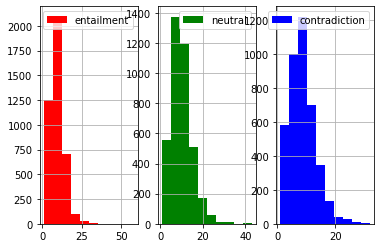

In [111]:
fig, ax = plt.subplots(1, 3)
train[train.label==0].hypothesis_len.hist(ax=ax[0], color='red', label='entailment', bins=10)
ax[0].legend();
train[train.label==1].hypothesis_len.hist(ax=ax[1], color='green', label='neutral', bins=10)
ax[1].legend();
train[train.label==2].hypothesis_len.hist(ax=ax[2], color='blue', label='contradiction', bins=10)
ax[2].legend();

It seems that hypothesis have much wider distribution despite having less words in the sentence on average. Still these are not really good metrics when dealing with several languages as some languages are more verbose than the others.

# Building an XLM-RoBERTa model

Natural Language Inference (NLI) is a specific type of NLP task where we must determine whether or not a hypothesis is true based on a premise. The current leading model in this field is RoBERTa. 
                     
RoBERTa, introduced at Facebook, Robustly optimized BERT approach. RoBERTa is a retraining of BERT with improved training methodology, 1000% more data and compute power.
                      
To improve the training procedure, RoBERTa removes the Next Sentence Prediction (NSP) task from BERT’s pre-training and introduces dynamic masking so that the masked token changes during the training epochs. Larger batch-training sizes were also found to be more useful in the training procedure. 